In [1]:
import pandas as pd
import numpy as np
%pylab inline
import glob
import warnings
warnings.filterwarnings("ignore")

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# reading data in batches and getting information from filename

In [2]:
path = 'results_date/'

def sample_type(string):
    if ('Std' in string) or ('STD' in string) or ('std' in string):
        return 'Std'
    if ('Blank' in string) or ('blank' in string):
        return 'Blank'
    if ('MHPool' in string) or ('MHPOOL' in string) or ('MHpool' in string):
        return 'MHPool'
    if ('SAPool' in string) or ('SAPOOL' in string) or ('SApool' in string):
        return 'SAPool'
    if 'ATCC' in string:
        return 'ATCC'
    return 'Bi'

files = sort(glob.glob(path + '*_vr_*.csv'))
dat_value = []
for file in files:
    d0 = pd.read_csv(file)
    datai = d0 #.set_index(['peak_label', 'ms_file'])['value'].unstack('peak_label').reset_index()
    datai['Date'] = datai.ms_file.apply(lambda x: re.findall(r'_(\d{6})', x)[0])
    datai['Col'] = datai.ms_file.apply(lambda x: 'Col'+ re.findall(r'Col(\d{2})', x)[0])
    datai['SType'] = datai.ms_file.apply(lambda x: sample_type(x))
    datai['Batch'] = datai.ms_file.apply(lambda x: x[:5])
    
   
    dat_value.append(datai)

# aggregating the data into one DF

In [3]:
dat_value1 = dat_value.copy()

for dat in dat_value1:
    for cp in np.unique(dat.peak_label):
        mean_mh = mean(dat.value[(dat.peak_label == cp) & (dat.SType =='MHPool')])
        dat.value[(dat.peak_label == cp)] /= mean_mh
        
dat_value[0]

,ms_file,peak_label,value,pred_conc,in_range,Date,Col,SType,Batch
0,SA017_G0_T0_210824_HILICNeg4S_Col01_RN00001_SG...,Acetoacetate,4.031257,0.283403,1.0,210824,Col01,Blank,SA017
1,SA017_G0_T0_210824_HILICNeg4S_Col01_RN00002_SG...,Acetoacetate,0.574378,0.040380,0.0,210824,Col01,Blank,SA017
2,SA017_G0_T0_210824_HILICNeg4S_Col01_RN00003_SG...,Acetoacetate,0.506953,0.035640,0.0,210824,Col01,Blank,SA017
3,SA017_G0_T0_210824_HILICNeg4S_Col01_RN00004_SG...,Acetoacetate,0.549231,0.038612,0.0,210824,Col01,Blank,SA017
4,SA017_G0_T0_210824_HILICNeg4S_Col01_RN00005_A1...,Acetoacetate,0.927623,0.065213,0.0,210824,Col01,Std,SA017
...,...,...,...,...,...,...,...,...,...
8003,SA017_G0_T0_210824_HILICNeg4S_Col01_RN00100_H0...,Xanthosine,0.830693,0.010600,1.0,210824,Col01,Bi,SA017
8004,SA017_G0_T0_210824_HILICNeg4S_Col01_RN00101_H0...,Xanthosine,0.705206,0.008999,1.0,210824,Col01,Bi,SA017
8005,SA017_G0_T0_210824_HILICNeg4S_Col01_RN00102_H1...,Xanthosine,0.997627,0.012730,1.0,210824,Col01,Bi,SA017
8006,SA017_G0_T0_210824_HILICNeg4S_Col01_RN00103_B1...,Xanthosine,1.095608,0.013981,1.0,210824,Col01,SAPool,SA017


In [4]:
cc_value = pd.concat(dat_value, axis = 0)

# collecting information about classes

In [5]:
Ab = pd.read_csv('200128-sw__APL-data__BI_NBR_and_resistance_info_SA.csv')
Ab.ORGANISM = Ab.ORGANISM.apply(lambda x: ('MS' + x)[-4:])
# np.unique(Ab.ORGANISM)
Ab.head()

cc_value['BI_NBR'] = 'NA'
cc_value.loc[cc_value.SType == 'Bi', 'BI_NBR'] = cc_value.ms_file[cc_value.SType == 'Bi'].apply(lambda x: x[-10:])

cc_value['ORGANISM'] = 'UNK'

for straint in np.unique(cc_value.BI_NBR):
#     print( (straint in np.unique(Ab.BI_NBR)))
    try:
        cc_value.loc[cc_value.BI_NBR == straint,'ORGANISM'] = Ab.ORGANISM[Ab.BI_NBR == straint].iloc[0]
#         print(straint)
    except:
        pass

# filtering for compounds with aceptable detection

In [6]:
metabs1 = ['Acetoacetate', 'Acetyl-Threonine', 'Adenine', 
         'Arabitol',
       'Arginine', 'Asparagine', 'Aspartate', 'Biotin', 'Carnosine',
       'Citrulline',   
       'Cytidine',   'Fumarate', 'Glucose',
       'Glucose-6-Phosphate',  'Glutamine', 
       'Hippurate', 'Histidine', 'Hypoxanthine', 
       'Itaconate',  'Lysine', 'Methionine', 'Methionine Sulfoxide',
       'Mevalonate acid', 'N-Acetyl-Aspartate',
       'N-Acetyl-Glutamate', 'N-Acetyl-Glutamine',
       'N-Acetyl-Glycine', 'N-Acetyl-Leucine', 'N-Acetyl-Methionine',
       'N-Acetyl-Phenylalanine', 'Nicotinate', 'O-Phospho-L-Serine',
       'Ornithine', 'Orotate', 'Panthothenic acid', 'Phenylalanine', 'Proline',
       'Pyridoxine', 'Rhamnose',  'Serine', 'Shikimate',
       'Succinate',  'Threonine', 'Thymidine', 'Thymine',
       'Trehalose', 'Tryptophan', 'Tyrosine', 'Uracil', 'Uridine',
       'Urocanate',  'Xanthine', 'Xanthosine']

cc_value['In'] = cc_value.peak_label.apply(lambda x: x in metabs1)
cc_value = cc_value[cc_value.In]

# calculating the relative intensities with respect to the media

In [7]:
cc_value['mean_bi'] = 0
for cp in np.unique(cc_value.peak_label):
    cc_value.loc[cc_value.peak_label == cp, 'mean_bi'] = mean(cc_value.value[(cc_value.peak_label == cp) & (cc_value.SType == 'Bi')])
    
cc_value.sort_values(by = ['mean_bi'], inplace = True)


cc_value.loc[cc_value.SType == 'MHPool', 'ORGANISM'] ='MH' 

# generating and printing the graph

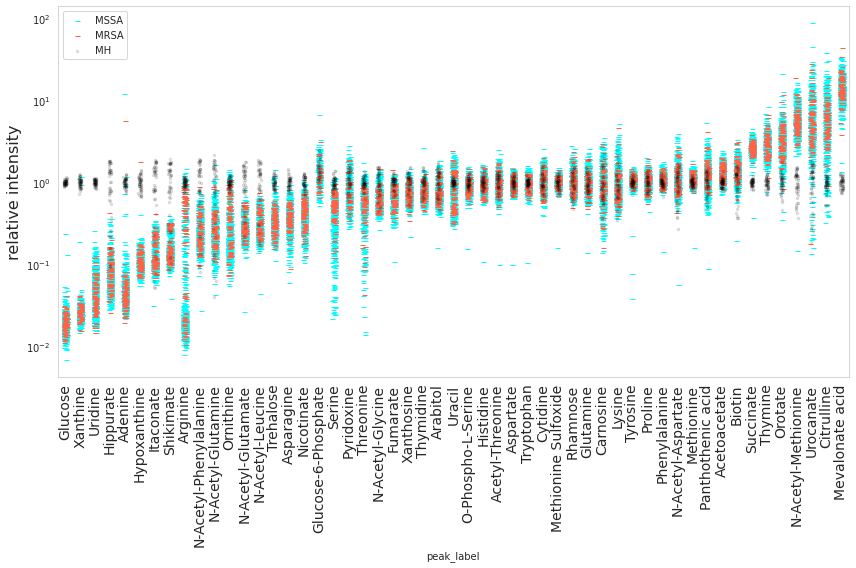

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# sorting metabolite names for x-tick labels
u, ind = np.unique(cc_value.peak_label, return_index=True)

colors = ["blue","red","gray"]
sns.set_style("whitegrid")
fig = plt.figure(figsize=(12,8))
dat = cc_value[(cc_value.ORGANISM == 'MSSA')]
ax = sns.stripplot(y='value', x='peak_label', data=dat, color='cyan',edgecolor='cyan', label = 'MSSA',marker="_", linewidth=1)
dat = cc_value[(cc_value.ORGANISM == 'MRSA')]
ax = sns.stripplot(y='value', x='peak_label', data=dat, color='tomato', edgecolor='tomato', label = 'MRSA',  marker="_", linewidth=1)
dat = cc_value[(cc_value.SType == 'MHPool')]
ax = sns.stripplot(y='value', x='peak_label', data=dat, color='black', alpha=.1 , edgecolor='black', label = 'MH', marker=".", linewidth=1)
ax.set_xticklabels(u[np.argsort(ind)],rotation=90, fontsize = 14)
# ax = sns.violinplot(y="Ornithine", x="ORGANISM", data=dat, color = 'gray')
plt.yscale('log')
plt.grid(False)
plt.ylabel('relative intensity', fontsize = 16)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0::len(metabs1)], labels[0::len(metabs1)])
plt.tight_layout()
plt.savefig('mrsa_vs_mssa_consumption_lower_point_size3.pdf')
plt.show()